筛选意图预测数据idx，场景：交叉路口

In [13]:
import argparse
import pickle
import copy
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
import matplotlib.pyplot as plt
from skimage.transform import rotate
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
from shapely.ops import unary_union
from shapely.geometry import Point
from shapely.geometry import Polygon

torch.cuda.set_device(0)

am = ArgoverseMap()

data_path = '/data/fyy/lanegcn/dataset/dataset/val/data'
avl = ArgoverseForecastingLoader(data_path)
avl.seq_list = sorted(avl.seq_list)


In [14]:

def get_traj_and_lane(idx): 
    city_name = copy.deepcopy(avl[idx].city)
    data_seq = copy.deepcopy(avl[idx].seq_df)   # (len, 6)
    timestamp = np.sort(np.unique(data_seq['TIMESTAMP'].values))
    
    mapping = dict()
    for i, ts in enumerate(timestamp):
        mapping[ts] = i
        
    # 某个场景下的所有轨迹，5s内的轨迹，(len, 2)
    trajs = np.concatenate((
            data_seq.X.to_numpy().reshape(-1, 1),
            data_seq.Y.to_numpy().reshape(-1, 1)), 1)

    steps = [mapping[x] for x in data_seq['TIMESTAMP'].values]
    steps = np.asarray(steps, np.int64)

    objs = data_seq.groupby(['TRACK_ID', 'OBJECT_TYPE']).groups
    keys = list(objs.keys())
    obj_type = [x[1] for x in keys]

    av_idx = obj_type.index('AV')  # av_index = 0，获取AV的索引
    idcs = objs[keys[av_idx]]

    av_traj = trajs[idcs]  # av_traj.shape = (50, 2)
    av_step = steps[idcs]  # av_step.shape = (50,)
    
    # 获取周围车辆的轨迹
    del keys[av_idx]
    ctx_trajs, ctx_steps = [], []  
    for key in keys:
        idcs = objs[key]
        ctx_trajs.append(trajs[idcs])
        ctx_steps.append(steps[idcs])
        
    data = dict()
    data['city'] = city_name
    data['trajs'] = [av_traj] + ctx_trajs
    data['steps'] = [av_step] + ctx_steps
    data['argo_id'] = int(avl.seq_list[idx].name[:-4])
    
    av_lane = am.get_lane_ids_in_xy_bbox(av_traj[0][0], av_traj[0][1], city_name, 5)
    return av_traj, av_lane, timestamp[0], city_name

# 读取PIT和MIA的十字路口的lane_id
intersection_data_path = [
    'intersection_data/PIT/intersection_PIT_id.pickle',
    'intersection_data/MIA/intersection_MIA_id.pickle'
]
intersection_data = {}
for path in intersection_data_path:
    with open(path, 'rb') as file:
        data = pickle.load(file)
    
    file_name = path.split('/')[-2]
    intersection_data[file_name] = data


# 统计意图预测的数据集，前20帧在停止先前，且至少5帧的轨迹在十字路口内（能够标注意图）
intention_data = []
for idx in tqdm(range(len(avl.seq_list))):
    av_traj, av_lane, _, city_name = get_traj_and_lane(idx)
    
    # 统计这条轨迹的周围路段
    traj_start, traj_end = av_traj[0], av_traj[-1]
    lane_nearest = am.get_lane_ids_in_xy_bbox(traj_start[0], traj_start[1], city_name, 5)
    lane_nearest += am.get_lane_ids_in_xy_bbox(traj_end[0], traj_end[1], city_name, 5)

    # 获取交叉路口的多边形
    intersection_polygon = []
    for lane_id in lane_nearest:
        if lane_id in intersection_data[city_name]:
            polygon = Polygon(am.get_lane_segment_polygon(lane_id, city_name))
            if polygon.is_valid:
                intersection_polygon.append(polygon)
    merged_polygon_intersection = unary_union(intersection_polygon) if intersection_polygon else None  
    
    # 获取直行道路的多边形
    straight_road_polygon = []
    for lane_id in lane_nearest:
        if lane_id in intersection_data[city_name]: continue
        polygon = Polygon(am.get_lane_segment_polygon(lane_id, city_name))
        if polygon.is_valid:
            straight_road_polygon.append(polygon)
    merged_polygon_straight_road = unary_union(straight_road_polygon) if straight_road_polygon else None
           
    # 统计轨迹在直行道路内的帧数       
    frames_inside_straight = 0
    for x, y in av_traj[:20]:
        point = Point(x, y)
        if merged_polygon_straight_road and merged_polygon_straight_road.contains(point):
            frames_inside_straight += 1
    
    # 统计轨迹在交叉路口内的帧数
    frames_inside_intersection = 0
    for x, y in av_traj[20:]:
        point = Point(x, y)
        if merged_polygon_intersection and merged_polygon_intersection.contains(point):
            frames_inside_intersection += 1

    if frames_inside_straight == 20 and frames_inside_intersection > 5:
        intention_data.append(idx)


  0%|          | 167/39472 [00:04<16:01, 40.87it/s]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [15]:
# file_name = '/data/fyy/new_prediction/argoverse/intersection_data/intention_val_av_idx.pkl'
file_name = '/data/fyy/new_prediction/argoverse_copy/intersection_data/intention_val_av_idx_inter_20_5.pkl'

# with open(file_name, 'wb') as file:
#     pickle.dump(intention_data, file)
    
with open(file_name, 'rb') as file:
    intention_data = pickle.load(file)

print("意图数据的数量", len(intention_data))

意图数据的数量 2505


提取对应idx轨迹, 生成测试集和训练集

In [16]:
def turn_direction(traj):
    # 计算第20帧的角度
    initial_vector = traj[0] - traj[3]
    initial_angle = np.arctan2(initial_vector[1], initial_vector[0])

    # 计算最后一帧的角度
    final_vector = traj[-5] - traj[-1]
    final_angle = np.arctan2(final_vector[1], final_vector[0])

    # 计算角度差异
    angle_threshold = np.pi / 12

    angle_diff = final_angle - initial_angle

    # 判断是否转向
    if abs(angle_diff) > angle_threshold:
        if angle_diff > 0:
            return [0, 1, 0]
        else:
            return [0, 0, 1]
    else:
        return [1, 0, 0]

In [17]:
traj_label = []
left, right, through = 0, 0, 0  # 左转 169, 右转 207, 直行 1053(200)
for idx in intention_data:
    av_traj, av_lane, _, city_name = get_traj_and_lane(idx)
    label = turn_direction(av_traj[20:])
    if label == [1, 0, 0] and through >= 200:
        continue
    if label == [0, 1, 0]:
        left += 1
    elif label == [0, 0, 1]:
        right += 1
    elif label == [1, 0, 0]:
        through += 1
    traj_label.append([av_traj[:20], label])


In [18]:
print("左转", left)
print("右转", right)
print("直行", through)
print("总数", len(traj_label))

左转 226
右转 304
直行 200
总数 730


In [16]:
# file_name = '/data/fyy/new_prediction/argoverse/intersection_data/intention_val_av_traj_and_label.pkl'

# with open(file_name, 'wb') as file:
#     pickle.dump(traj_label, file)

生成预测的轨迹(准确率低,不行)

In [2]:
from torch.utils.data import DataLoader
from data import ArgoTestDataset
from utils import load_pretrain

torch.cuda.set_device(1)
from lanegcn import get_model
config, Dataset, collate_fn, net, loss, post_process, opt = get_model()

ckpt_path_g = '/data/fyy/new_prediction/argoverse/generator32.000.ckpt'
ckpt_g = torch.load(ckpt_path_g, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt_g["state_dict"])

net.eval()
net.cuda()

dataset = ArgoTestDataset('val', config, train=False)

data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=True,
)

In [3]:
preds = {}
gts = {}
cities = {}

for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    with torch.no_grad():
        rel, output = net(data)
        results = [x[0:1].detach().cpu().numpy() for x in output["reg"]]
    for i, (argo_idx, pred_traj) in enumerate(zip(data["argo_id"], results)):
        preds[argo_idx] = pred_traj.squeeze()
        cities[argo_idx] = data["city"][i]
        gts[argo_idx] = data["gt_preds"][i][0] if "gt_preds" in data else None

# save for further visualizations
res = dict(
    preds = preds,
    gts = gts,
    cities = cities,
)

1234it [02:25,  8.48it/s]


In [9]:
file_name = '/data/fyy/new_prediction/argoverse/intersection_data/intention_val_agent_idx.pkl'
with open(file_name, 'rb') as file:
    intention_data = pickle.load(file)

def get_data(idx): 
    city_name = copy.deepcopy(avl[idx].city)
    data_seq = copy.deepcopy(avl[idx].seq_df)   # (len, 6)
    timestamp = np.sort(np.unique(data_seq['TIMESTAMP'].values))
    
    mapping = dict()
    for i, ts in enumerate(timestamp):
        mapping[ts] = i
        
    # 某个场景下的所有轨迹，5s内的轨迹，(len, 2)
    trajs = np.concatenate((
            data_seq.X.to_numpy().reshape(-1, 1),
            data_seq.Y.to_numpy().reshape(-1, 1)), 1)

    steps = [mapping[x] for x in data_seq['TIMESTAMP'].values]
    steps = np.asarray(steps, np.int64)

    objs = data_seq.groupby(['TRACK_ID', 'OBJECT_TYPE']).groups
    keys = list(objs.keys())
    obj_type = [x[1] for x in keys]

    av_idx = obj_type.index('AV')  # av_index = 0，获取AV的索引
    idcs = objs[keys[av_idx]]

    av_traj = trajs[idcs]  # av_traj.shape = (50, 2)
    av_step = steps[idcs]  # av_step.shape = (50,)
    
    # 获取周围车辆的轨迹
    del keys[av_idx]
    ctx_trajs, ctx_steps = [], []  
    for key in keys:
        idcs = objs[key]
        ctx_trajs.append(trajs[idcs])
        ctx_steps.append(steps[idcs])
        
    data = dict()
    data['city'] = city_name
    data['trajs'] = [av_traj] + ctx_trajs
    data['steps'] = [av_step] + ctx_steps
    data['argo_id'] = int(avl.seq_list[idx].name[:-4])

    orig = data['trajs'][0][19].copy().astype(np.float32)
    pre = data['trajs'][0][18] - orig
    theta = np.pi - np.arctan2(pre[1], pre[0])

    rot = np.asarray([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]], np.float32)


    feats, ctrs, gt_preds, has_preds, traj1, trajs2 = [], [], [], [], [], []
    for traj, step in zip(data['trajs'], data['steps']):
        if 19 not in step:
            continue
            
        gt_pred = np.zeros((30, 2), np.float32)
        has_pred = np.zeros(30, bool)
        future_mask = np.logical_and(step >= 20, step < 50)
        post_step = step[future_mask] - 20
        post_traj = traj[future_mask]
        gt_pred[post_step] = post_traj
        has_pred[post_step] = 1


        all_traj = traj.copy().astype(np.float32)
        has_traj = np.zeros(50, bool)
        all_mask = np.logical_and(step >= 0, step < 50)
        all_traj = traj[all_mask]
        all_step = step[all_mask]
        # print(all_traj)
        has_traj[all_step] = 1

        obs_mask = step < 20
        step = step[obs_mask]
        traj = traj[obs_mask]
        idcs = step.argsort()
        step = step[idcs]
        traj = traj[idcs]

        for i in range(len(step)):
            if step[i] == 19 - (len(step) - 1) + i:
                break
        step = step[i:]
        traj = traj[i:]


        feat = np.zeros((20, 3), np.float32)
        feat[step, :2] = np.matmul(rot, (traj - orig.reshape(-1, 2)).T).T
        feat[step, 2] = 1.0


        traj2 = np.zeros((50,3), np.float32)
        traj2[all_step, :2] = np.matmul(rot, (all_traj - orig.reshape(-1,2)).T).T
        traj2[all_step, 2] = 1
        

        x_min, x_max, y_min, y_max = [-100.0, 100.0, -100.0, 100.0]
        if feat[-1, 0] < x_min or feat[-1, 0] > x_max or feat[-1, 1] < y_min or feat[-1, 1] > y_max:
            continue

        ctrs.append(feat[-1, :2].copy())
        traj1.append(feat.copy())

        feat[1:, :2] -= feat[:-1, :2]
        feat[step[0], :2] = 0
        feats.append(feat)
        gt_preds.append(gt_pred)
        has_preds.append(has_pred)
        trajs2.append(traj2)

    feats = np.asarray(feats, np.float32)
    ctrs = np.asarray(ctrs, np.float32)
    gt_preds = np.asarray(gt_preds, np.float32)
    has_preds = np.asarray(has_preds, bool)
    traj1 = np.asarray(traj1, np.float32)
    trajs2 = np.asarray(trajs2, np.float32)

    data['feats'] = feats
    data['traj1'] = traj1
    data['ctrs'] = ctrs
    data['orig'] = orig
    data['theta'] = theta
    data['rot'] = rot
    data['gt_preds'] = gt_preds
    data['has_preds'] = has_preds
    data['trajs2'] = trajs2
    return data

In [19]:
# 读取val预测的结果
file_name = '/data/fyy/new_prediction/argoverse/intersection_data/val_pred.pkl'  
with open(file_name, 'rb') as file:
    preds = pickle.load(file)
print(len(preds))

39472


In [35]:
################使用这个########################
def turn_direction(traj, city_name):
    if am.get_lane_segments_containing_xy(traj[19][0], traj[19][1], city_name) == []:
        return None  
    lane_id_start = am.get_lane_segments_containing_xy(traj[19][0], traj[19][1], city_name)
    for id in lane_id_start:
        direction_start = am.get_lane_turn_direction(id, city_name)
        polygon = am.get_lane_segment_polygon(id, city_name)
        plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple') 

    if am.get_lane_segments_containing_xy(traj[49][0], traj[49][1], city_name) == []:
        return None
    lane_id_end = am.get_lane_segments_containing_xy(traj[49][0], traj[49][1], city_name)
    for id in lane_id_end:
        direction_end = am.get_lane_turn_direction(id, city_name)
        polygon = am.get_lane_segment_polygon(id, city_name)
        plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')
    
    if direction_start == 'NONE' and direction_end == 'LEFT':
        return [0, 1, 0]
    elif direction_start == 'NONE' and direction_end == 'RIGHT':
        return [0, 0, 1]
    elif direction_start == 'NONE' and direction_end == 'NONE':
        return [1, 0, 0]
    else:
        return None

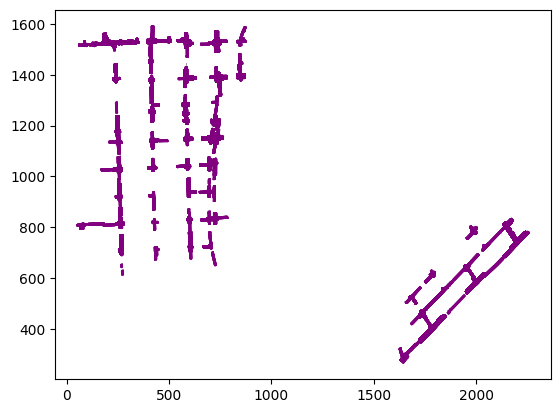

In [36]:
total = 0
correct = 0
correct_idx = []
s, l, r = [], [], []

for i in range(len(intention_data)):
    idx = intention_data[i]
    data = get_data(idx)
    city_name = data['city']
    orig = data['orig']
    seq_id = data['argo_id']
    rot = data['rot']
    trajs_obs = data['trajs']
    traj_real = trajs_obs[0]
    traj_pred = np.concatenate((traj_real[:20], preds[seq_id][0]), axis=0)   
    if turn_direction(traj_real, city_name) == None or turn_direction(traj_pred, city_name) == None:
        continue
    total += 1
    if turn_direction(traj_real, city_name) == turn_direction(traj_pred, city_name) and turn_direction(traj_real, city_name) == [1, 0, 0]:
        correct += 1
        s.append(idx)
        correct_idx.append(idx)
    elif turn_direction(traj_real, city_name) == turn_direction(traj_pred, city_name) and turn_direction(traj_real, city_name) == [0, 1, 0]:
        correct += 1
        l.append(idx)
        correct_idx.append(idx)
    elif turn_direction(traj_real, city_name) == turn_direction(traj_pred, city_name) and turn_direction(traj_real, city_name) == [0, 0, 1]:
        correct += 1
        r.append(idx)
        correct_idx.append(idx)

In [37]:
print("直行数据数量：", len(s))
print("左转数据数量：", len(l))
print("右转数据数量：", len(r))
print("准确率", correct / total)


直行数据数量： 1886
左转数据数量： 218
右转数据数量： 38
准确率 0.9049429657794676


True


(1724.6898668078024, 1801.5550273477163, 344.2705773723387, 409.5538133232198)

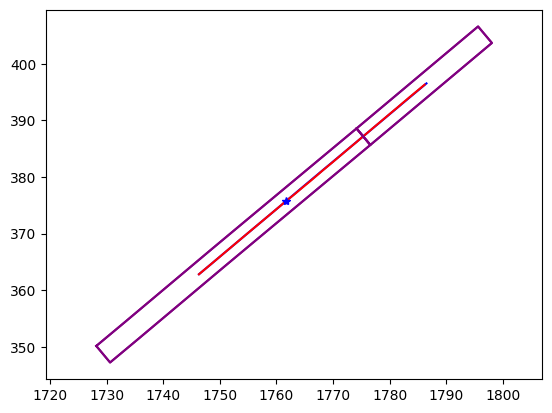

In [58]:
i = 6
idx = s[i]
data = get_data(idx)
city_name = data['city']
orig = data['orig']
seq_id = data['argo_id']
rot = data['rot']
trajs_obs = data['trajs']
traj_real = trajs_obs[0]
traj_pred = np.concatenate((traj_real[:20], preds[seq_id][0]), axis=0)    # fake
plt.plot(traj_real[:, 0], traj_real[:, 1], 'b')
plt.plot(traj_pred[:, 0], traj_pred[:, 1], 'r')
plt.plot(traj_real[19, 0], traj_real[19, 1], 'b*')
print(turn_direction(traj_real, city_name) == turn_direction(traj_pred, city_name))
plt.axis('equal')

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from vis_utils import ArgoMapVisualizer
map_vis = ArgoMapVisualizer()

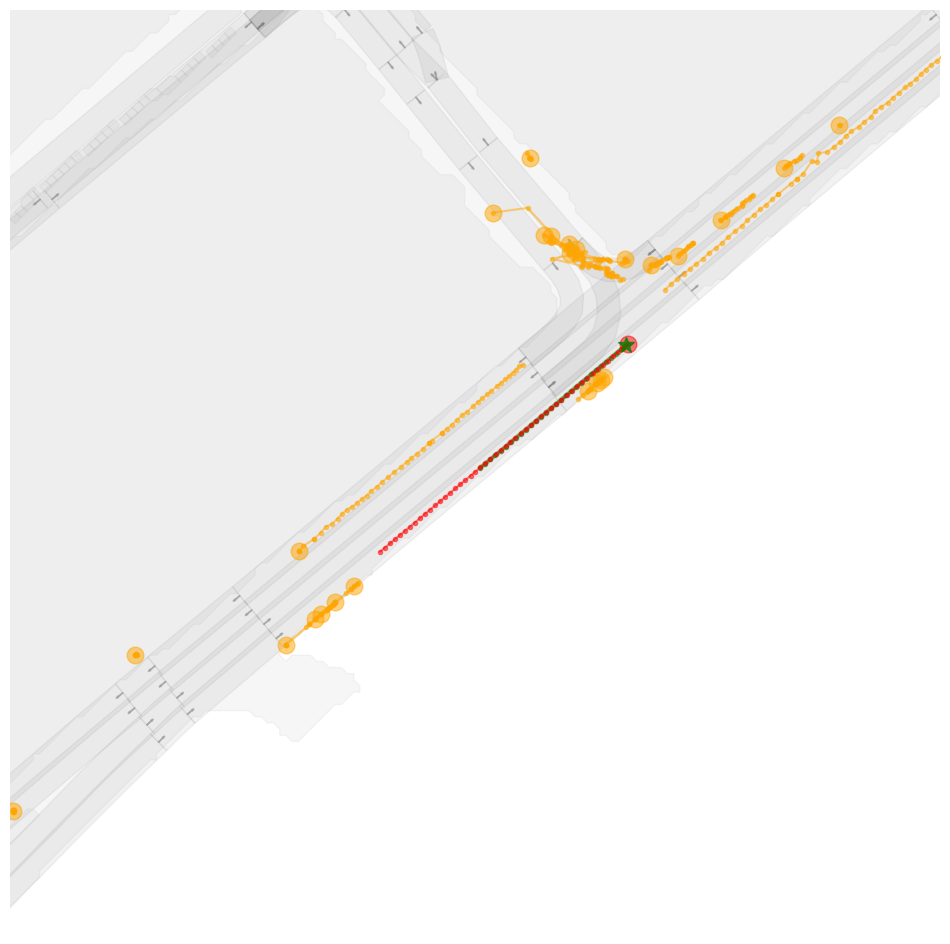

In [59]:

_, ax = plt.subplots(figsize=(12, 12))
ax.axis('equal')
plt.axis('off')
map_vis.show_surrounding_elements(ax, city_name, orig)

for i, traj in enumerate(trajs_obs):
    traj = trajs_obs[i]
    # traj = torch.tensor(traj)
    # mask = torch.any(traj != 0, dim=1)
    # traj = traj[mask]
    # traj = np.matmul(rot.T, traj.T).T + orig
    zorder = 10
    if i == 0:
        clr = 'r'
        zorder = 20
    else:
        clr = 'orange'
    ax.plot(traj[:, 0], traj[:, 1], marker='.', alpha=0.5, color=clr, zorder=zorder)
    ax.plot(traj[-1, 0], traj[-1, 1], alpha=0.5, color=clr, marker='o', zorder=zorder, markersize=12)

av_traj_pred = traj_pred[20:]
ax.plot(av_traj_pred[:, 0], av_traj_pred[:, 1], alpha=0.5, color='g', linewidth=3, marker='.', zorder=15)
ax.plot(av_traj_pred[-1, 0], av_traj_pred[-1, 1], marker='*', color='g', markersize=12, alpha=0.75, zorder=30)
plt.savefig('my_plotb3_5.png', format='png', dpi=300)


In [26]:
def turn_direction(traj):
    # 计算第20帧的角度
    initial_vector = traj[0] - traj[3]
    initial_angle = np.arctan2(initial_vector[1], initial_vector[0])

    # 计算最后一帧的角度
    final_vector = traj[-5] - traj[-1]
    final_angle = np.arctan2(final_vector[1], final_vector[0])

    # 计算角度差异
    angle_threshold = np.pi / 12

    angle_diff = final_angle - initial_angle

    # 判断是否转向
    if abs(angle_diff) > angle_threshold:
        if angle_diff > 0:
            return 1
        else:
            return 2
    else:
        return 0

In [27]:
labels_real = [-1]*len(intention_data)  # 0:直行，1:左拐，2:右拐
labels_pred = [-1]*len(intention_data)
num = 0
for i in range(len(intention_data)):
    idx = intention_data[i]
    data = get_data(idx)
    orig = data['orig']
    seq_id = data['argo_id']
    rot = data['rot']
    trajs_obs = data['trajs2'][:, 20:, :2][0]
    traj_pred = preds[seq_id][0]
    traj = torch.tensor(trajs_obs)
    mask = torch.any(traj != 0, dim=1)
    traj = traj[mask]
    traj = np.matmul(rot.T, traj.T).T + orig

    # real_label = turn_direction(traj)     # 均衡三个意图的数量
    # if real_label == 0 and num < 300:
    #     num += 1
    # if real_label == 0 and num == 300:
    #     continue

    labels_real[i] = turn_direction(traj)
    labels_pred[i] = turn_direction(traj_pred)
#     break
# plt.plot(traj[:, 0], traj[:, 1], '-o', color='blue', linewidth=1)
# plt.plot(traj_pred[:, 0], traj_pred[:, 1], '-o', color='red', linewidth=1)
# plt.axis('equal')
# print("真实的标签：", turn_direction(traj))
# print("预测的标签：", turn_direction(traj_pred))


In [28]:
from collections import Counter
from sklearn.metrics import accuracy_score

class_counts = Counter(labels_real)
# 输出每个类的数量
for label, count in class_counts.items():
    print(f"Class {label}: Count {count}")
    

# accuracy = accuracy_score(labels_real, labels_pred)
# print("Accuracy:", accuracy)

correct = 0
erro_id = []
total = 0
for i in range(len(labels_real)):
    if labels_real[i] == -1:
        continue
    total += 1
    if labels_real[i] == labels_pred[i]:
        correct += 1
    else:
        erro_id.append(i)
print("Correct:", correct)
print("Total:", total)
print("Accuracy:", correct/total)


Class 0: Count 1976
Class 1: Count 225
Class 2: Count 304
Correct: 2153
Total: 2505
Accuracy: 0.8594810379241516
